In [45]:
# initial setup
try:
    # settings colab:
    import google.colab
        
except ModuleNotFoundError:    
    # settings local:
    %run "../../../common/0_notebooks_base_setup.py"

pandas=1.0.3 already installed
matplotlib=2.2.2 already installed
bokeh=2.0.0 already installed
seaborn=0.10.0 already installed


In [46]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import chart_studio
import chart_studio.plotly as py
import unidecode as ud

In [47]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.width', 5000)

In [48]:
import chardet
def get_encoding_type(csv_path):
    rawdata = open(csv_path, 'rb').read()
    result = chardet.detect(rawdata)
    return result.get('encoding')

In [49]:
data = pd.read_csv("properati.csv")

In [50]:
#Creo una copia del DF
data_clean = data.copy(deep=True)

<span style="font-size:24px">NULOS AL INICIO<span>

In [51]:
priceAproxUSDNulosInicio = data_clean.price_aprox_usd.isnull().sum()
priceUSDPerM2NulosInicio = data_clean.price_usd_per_m2.isnull().sum()
surfaceTotalInM2NulosInicio = data_clean.surface_total_in_m2.isnull().sum()

<hr>
<span style="font-size:24px">COMPLETAR price_aprox_usd<span>

In [52]:
regex = re.compile("USD\s+[\d|.]{3,10}", flags = re.IGNORECASE)
regexPrecio = data_clean[(data_clean.price_aprox_usd.isnull())].description.apply(lambda x: regex.search(str(x)))
resultado = regexPrecio.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace("usd", "").replace(".", "").strip()).astype(np.float64)
print("Antes: ", data_clean.price_aprox_usd.isnull().sum())
data_clean.loc[resultado.index, "price_aprox_usd"]  = resultado
print("Después: ", data_clean.price_aprox_usd.isnull().sum())

Antes:  20410
Después:  20274


In [53]:
regexPrecio = data_clean[(data_clean.price_aprox_usd.isnull())].title.apply(lambda x: regex.search(str(x)))
resultado = regexPrecio.apply(lambda x: np.NaN if x is None else x.group(0).lower().replace("usd", "").replace(".", "").strip()).astype(np.float64)
print("Antes: ", data_clean.price_aprox_usd.isnull().sum())
data_clean.loc[resultado.index, "price_aprox_usd"]  = resultado
print("Después: ", data_clean.price_aprox_usd.isnull().sum())

Antes:  20274
Después:  20273


<hr>
<span style="font-size:24px">COMPLETAR price_usd_per_m2<span>

<hr>
<span style="font-size:18px">NULOS price_usd_per_m2<span>

In [54]:
#Buscar nulos
priceUSDPerM2NullMask = data_clean.price_usd_per_m2.isnull()
print("Nulos: ", priceUSDPerM2NullMask.sum(), "\n")
display(data_clean[priceUSDPerM2NullMask].head(2))

Nulos:  52603 



,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...


In [55]:
#Nulos por tipo de propiedad
popertyTypeGroupBy1 = data_clean[priceUSDPerM2NullMask].groupby(by="property_type")
popertyTypeGroupBy1["property_type"].count()

#Con esto se puede iterar sobre cada grupo y ver los registros por separado
#for name, group in popertyTypeGroupBy1: 
#    display(name) 
#    display(group) 
#    print() 

property_type
PH            2497
apartment    28178
house        19909
store         2019
Name: property_type, dtype: int64

<hr>
<span style="font-size:18px">NULOS price_per_m2<span>

In [56]:
#Buscar nulos
pricePerM2NullMask = data_clean.price_per_m2.isnull()
print(pricePerM2NullMask.sum())
display(data_clean[pricePerM2NullMask].filter(items=["price_per_m2", "currency"]).head(5))

33562


,price_per_m2,currency
1,NaN,USD
3,NaN,USD
5,NaN,NaN
9,NaN,ARS
10,NaN,USD


In [57]:
#Nulos por tipo de propiedad
popertyTypeGroupBy2 = data_clean[pricePerM2NullMask].groupby(by="property_type")
popertyTypeGroupBy2["property_type"].count()

property_type
PH            1199
apartment    18871
house        11915
store         1577
Name: property_type, dtype: int64

<hr>
<span style="font-size:18px">IMPUTAR VALORES EN price_usd_per_m2 a partir de price_per_m2<span>

In [58]:
#Buscar price_per_m2 en USD para imputar en price_usd_per_m2
pricePerM2NoNulos = data_clean[(priceUSDPerM2NullMask) & \
                   (~pricePerM2NullMask) & \
                   (data_clean.currency == "USD")].price_per_m2
display(pricePerM2NoNulos.head(3))

68    3263.888889
77    1764.705882
79    2809.523810
Name: price_per_m2, dtype: float64

In [59]:
print("Nulos antes: ", data_clean.price_usd_per_m2.isnull().sum())
data_clean.loc[pricePerM2NoNulos.index, "price_usd_per_m2"] = pricePerM2NoNulos
print("Nulos después: ", data_clean.price_usd_per_m2.isnull().sum())


Nulos antes:  52603
Nulos después:  31166


In [60]:
#Buscar price_por_m2 en pesos
display(data_clean[(priceUSDPerM2NullMask) & \
                   (~pricePerM2NullMask) & \
                   (data_clean.currency == "ARG")].filter(items=["price_usd_per_m2", "price_per_m2", "currency"]))

,price_usd_per_m2,price_per_m2,currency


<hr>
<span style="font-size:18px">IMPUTAR VALORES EN price_usd_per_m2 CRUZANDO POR UBICACIONES y precio_aprox_usd<span>

In [61]:
#Apartment sin price_usd_per_m2 con price_aprox_usd
data_clean["Indice"] = data_clean.index
dfGrupo1 = data_clean[(data_clean.price_usd_per_m2.isnull()) & (data_clean.price_aprox_usd.notnull())].filter(items=["property_type", "Indice", "state_name", "place_name", "place_with_parent_names", "price_aprox_usd"])
#Apartment con price_usd_per_m2 y con price_aprox_usd
dfGrupo2 = data_clean[(data_clean.price_usd_per_m2.notnull()) & (data_clean.price_aprox_usd.notnull())].filter(items=["property_type", "state_name", "place_name", "place_with_parent_names", "price_usd_per_m2", "price_aprox_usd"])

In [62]:
print("Nulos antes: ", data_clean.price_usd_per_m2.isnull().sum())
gruposMerge = pd.merge(dfGrupo1, dfGrupo2, how="inner", on=["property_type", "place_with_parent_names", "price_aprox_usd"])
medianaPriceUSDPerM2 = gruposMerge.groupby(by=["property_type", "Indice"])[['price_usd_per_m2']].median()
medianaPriceUSDPerM2.reset_index(inplace=True)
medianaPriceUSDPerM2.set_index(["Indice"], inplace=True)
data_clean.loc[gruposMerge.Indice, "price_usd_per_m2"] = medianaPriceUSDPerM2.price_usd_per_m2
print("Nulos después: ", data_clean.price_usd_per_m2.isnull().sum())


Nulos antes:  31166
Nulos después:  25110


In [63]:
print("Nulos antes: ", data_clean.price_usd_per_m2.isnull().sum())
gruposMerge = pd.merge(dfGrupo1, dfGrupo2, how="inner", on=["property_type", "place_name", "price_aprox_usd"])
medianaPriceUSDPerM2 = gruposMerge.groupby(by=["property_type", "Indice"])[['price_usd_per_m2']].median()
medianaPriceUSDPerM2.reset_index(inplace=True)
medianaPriceUSDPerM2.set_index(["Indice"], inplace=True)
data_clean.loc[gruposMerge.Indice, "price_usd_per_m2"] = medianaPriceUSDPerM2.price_usd_per_m2
print("Nulos después: ", data_clean.price_usd_per_m2.isnull().sum())

Nulos antes:  25110
Nulos después:  24821


In [64]:
print("Nulos antes: ", data_clean.price_usd_per_m2.isnull().sum())
gruposMerge = pd.merge(dfGrupo1, dfGrupo2, how="inner", on=["property_type", "state_name", "price_aprox_usd"])
medianaPriceUSDPerM2 = gruposMerge.groupby(by=["property_type", "Indice"])[['price_usd_per_m2']].median()
medianaPriceUSDPerM2.reset_index(inplace=True)
medianaPriceUSDPerM2.set_index(["Indice"], inplace=True)
data_clean.loc[gruposMerge.Indice, "price_usd_per_m2"] = medianaPriceUSDPerM2.price_usd_per_m2
print("Nulos después: ", data_clean.price_usd_per_m2.isnull().sum())

Nulos antes:  24821
Nulos después:  22825


In [65]:
print("Nulos antes: ", data_clean.price_usd_per_m2.isnull().sum())
gruposMerge = pd.merge(dfGrupo1, dfGrupo2, how="inner", on=["property_type", "place_with_parent_names"])
medianaPriceUSDPerM2 = gruposMerge.groupby(by=["property_type", "Indice"])[['price_usd_per_m2']].median()
medianaPriceUSDPerM2.reset_index(inplace=True)
medianaPriceUSDPerM2.set_index(["Indice"], inplace=True)
data_clean.loc[gruposMerge.Indice, "price_usd_per_m2"] = medianaPriceUSDPerM2.price_usd_per_m2
print("Nulos después: ", data_clean.price_usd_per_m2.isnull().sum())

Nulos antes:  22825
Nulos después:  20374


In [66]:
print("Nulos antes: ", data_clean.price_usd_per_m2.isnull().sum())
gruposMerge = pd.merge(dfGrupo1, dfGrupo2, how="inner", on=["property_type", "place_name"])
medianaPriceUSDPerM2 = gruposMerge.groupby(by=["property_type", "Indice"])[['price_usd_per_m2']].median()
medianaPriceUSDPerM2.reset_index(inplace=True)
medianaPriceUSDPerM2.set_index(["Indice"], inplace=True)
data_clean.loc[gruposMerge.Indice, "price_usd_per_m2"] = medianaPriceUSDPerM2.price_usd_per_m2
print("Nulos después: ", data_clean.price_usd_per_m2.isnull().sum())

Nulos antes:  20374
Nulos después:  20350


In [67]:
print("Nulos antes: ", data_clean.price_usd_per_m2.isnull().sum())
gruposMerge = pd.merge(dfGrupo1, dfGrupo2, how="inner", on=["property_type", "state_name"])
medianaPriceUSDPerM2 = gruposMerge.groupby(by=["property_type", "Indice"])[['price_usd_per_m2']].median()
medianaPriceUSDPerM2.reset_index(inplace=True)
medianaPriceUSDPerM2.set_index(["Indice"], inplace=True)
data_clean.loc[gruposMerge.Indice, "price_usd_per_m2"] = medianaPriceUSDPerM2.price_usd_per_m2
print("Nulos después: ", data_clean.price_usd_per_m2.isnull().sum())

Nulos antes:  20350
Nulos después:  20278


In [68]:
dfOtros1 = data_clean[(data_clean.price_aprox_usd.notnull()) & (data_clean.surface_total_in_m2.notnull()) & (data_clean.price_usd_per_m2.isnull())]

In [69]:
dfOtros2 = data_clean[(data_clean.price_aprox_usd.notnull()) & (data_clean.surface_covered_in_m2.notnull()) & (data_clean.price_usd_per_m2.isnull())]

In [70]:
data_clean.loc[dfOtros2.index, "price_usd_per_m2"] = data_clean.loc[dfOtros2.index, "price_aprox_usd"] / data_clean.loc[dfOtros2.index, "surface_covered_in_m2"]

<hr>
<span style="font-size:18px">IMPUTAR VALORES EN surface_total_in_m2 CON price_aprox_usd / price_usd_per_m2<span>

In [71]:
surfaceTotalInM2NullMask = (data_clean.surface_total_in_m2.isnull()) & \
                           (data_clean.price_aprox_usd.notnull()) & \
                           (data_clean.price_usd_per_m2.notnull())

print("Antes: ", data_clean.surface_total_in_m2.isnull().sum())
data_clean.loc[surfaceTotalInM2NullMask, "surface_total_in_m2"] = \
    data_clean.loc[surfaceTotalInM2NullMask, "price_aprox_usd"] / data_clean.loc[surfaceTotalInM2NullMask, "price_usd_per_m2"]
print("Despues: ", data_clean.surface_total_in_m2.isnull().sum())

Antes:  39328
Despues:  7336


In [72]:
regex = re.compile("[\d|.]{3,10}\sm2|superficie\s[\d|.]{3,10}", flags = re.IGNORECASE)
regexSuperficie = data_clean[(data_clean.surface_total_in_m2.isnull()) & \
                             ((data_clean.property_type == "PH") | \
                             (data_clean.property_type == "apartment") | \
                             (data_clean.property_type == "house"))].description.apply(lambda x: regex.search(str(x)))
resultadoSuperficie = regexSuperficie.apply(lambda x: np.NaN if x is None else x.group(0))
resultadoSuperficieMaskNotNull = resultadoSuperficie.notnull()
resultadoSuperficieSinNulos = resultadoSuperficie[resultadoSuperficieMaskNotNull]
print("Antes: ", data_clean.surface_total_in_m2.isnull().sum())
data_clean.loc[resultadoSuperficieSinNulos.index, "surface_total_in_m2"] = resultadoSuperficieSinNulos
print("Despues: ", data_clean.surface_total_in_m2.isnull().sum())

Antes:  7336
Despues:  6630


In [73]:
dfSuperficies1 = data_clean.loc[resultadoSuperficieSinNulos.index, :]
dfSuperficies2 = dfSuperficies1[(dfSuperficies1.price_aprox_usd.notnull()) & (dfSuperficies1.price_usd_per_m2.isnull())]
dfSuperficies2.filter(items=["price_aprox_usd", "surface_total_in_m2"])

,price_aprox_usd,surface_total_in_m2


<hr>
<span style="font-size:18px">% DE REDUCCION DE NULOS<span>

In [74]:
priceAproxUSDNulosFin = data_clean.price_aprox_usd.isnull().sum()
priceUSDPerM2NulosFin = data_clean.price_usd_per_m2.isnull().sum()
surfaceTotalInM2NulosFin = data_clean.surface_total_in_m2.isnull().sum()

In [79]:
porcPriceAproxUSDNulos = 100 - (priceAproxUSDNulosFin / priceAproxUSDNulosInicio * 100)
porcPriceUSDPerM2Nulos = 100 - (priceUSDPerM2NulosFin / priceUSDPerM2NulosInicio * 100)
porcSurfaceTotalInM2Nulos = 100 - (surfaceTotalInM2NulosFin / surfaceTotalInM2NulosInicio * 100)
print("% reducción de nulos price_aprox_usd: ", porcPriceAproxUSDNulos)
print("% reducción de nulos price_usd_per_m2: ", porcPriceUSDPerM2Nulos)
print("% reducción de nulos surface_total_in_m2: ", porcSurfaceTotalInM2Nulos)

% reducción de nulos price_aprox_usd:  0.6712395884370466
% reducción de nulos price_usd_per_m2:  61.45276885348744
% reducción de nulos surface_total_in_m2:  83.14178193653376


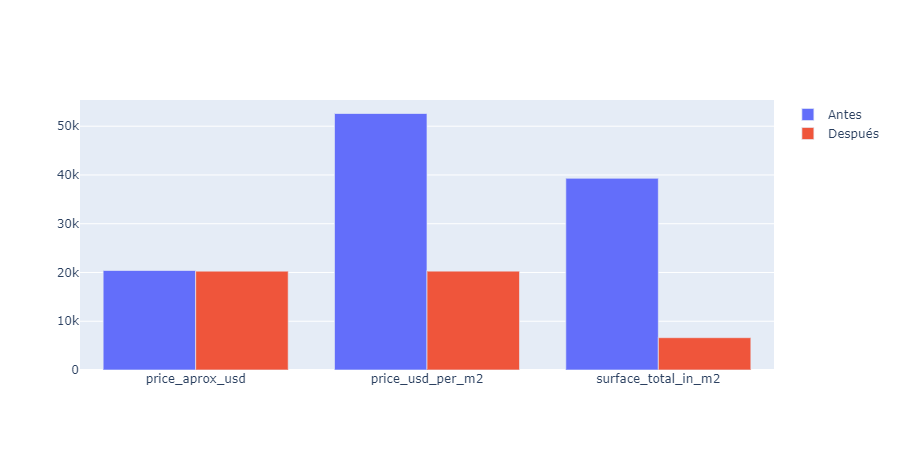

In [76]:
arrayVariables=["price_aprox_usd", "price_usd_per_m2", "surface_total_in_m2"]

fig = go.Figure(data=[
    go.Bar(name='Antes', x=arrayVariables, y=[priceAproxUSDNulosInicio, priceUSDPerM2NulosInicio, surfaceTotalInM2NulosInicio]),
    go.Bar(name='Después', x=arrayVariables, y=[priceAproxUSDNulosFin, priceUSDPerM2NulosFin, surfaceTotalInM2NulosFin])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()